# Data Download

In [1]:
!mkdir train
!mkdir test
!wget http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar -P train/
!wget http://pjreddie.com/media/files/VOCtest_06-Nov-2007.tar -P test/
!tar -xf test/VOCtest_06-Nov-2007.tar -C test/
!tar -xf train/VOCtrainval_06-Nov-2007.tar -C train/
!rm -rf train/VOCtest_06-NOV-2007.tar
!rm -rf test/VOCtest_06-Nov-2007.tar

--2021-03-04 12:10:29--  http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar [following]
--2021-03-04 12:10:30--  https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/octet-stream]
Saving to: ‘train/VOCtrainval_06-Nov-2007.tar’

VOCtrainval_06-Nov- 100%[===================>] 438.72M  40.1MB/s    in 11s     

2021-03-04 12:10:41 (40.0 MB/s) - ‘train/VOCtrainval_06-Nov-2007.tar’ saved [460032000/460032000]

URL transformed to HTTPS due to an HSTS policy
--2021-03-04 12:10:41--  https://pjreddie.com/media/files/VOCtest_06-Nov-2007.tar
Resolving pjreddie.com (

In [1]:
import torch
import os
import pandas as pd
from PIL import Image
import xml.etree.ElementTree as ET
import pickle
import os
from os import listdir, getcwd
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import Counter
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
from tqdm import tqdm
from torch.utils.data import DataLoader

# Conver to csv

make a annotation txt file and matching with image file

merge into csv file

In [2]:


sets = [('train', 'train'), ('train', 'val'), ('test', 'test')]

classes = ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", 
           "car", "cat", "chair", "cow", "diningtable", "dog", "horse", 
           "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]

def convert(size, box):
  dw = 1./size[0]
  dh = 1./size[1]
  x = (box[0] + box[1])/2.
  y = (box[2] + box[3])/2.
  w = box[1]-box[0]
  h = box[3]-box[2]
  x = x*dw
  w = w*dw
  y = y*dh
  h = h*dh
  return (x, y, w, h)

def convert_annotation(mode, image_id):
  in_file = open('{}/VOCdevkit/VOC2007/Annotations/{}.xml'.format(mode, image_id))
  out_file = open('{}/VOCdevkit/VOC2007/labels/{}.txt'.format(mode, image_id), 'w')

  tree = ET.parse(in_file)
  root = tree.getroot()
  size = root.find('size')
  w = int(size.find('width').text)
  h = int(size.find('height').text)

  for obj in root.iter('object'):
    difficult = obj.find('difficult').text
    cls = obj.find('name').text
    if cls not in classes or int(difficult) == 1:
      continue
    cls_id = classes.index(cls)
    xmlbox = obj.find('bndbox')
    #b : [xmin, xmax, ymin, xmax]
    b = (float(xmlbox.find('xmin').text), float(xmlbox.find('xmax').text), 
          float(xmlbox.find('ymin').text), float(xmlbox.find('ymax').text))
    bb = convert((w,h), b)
    out_file.write(str(cls_id) + " " + " ".join([str(a) for a in bb]) + '\n')

wd = getcwd()

for mode, image_set in sets:
  if not os.path.exists('{}/VOCdevkit/VOC2007/labels/'.format(mode)):
    os.makedirs('{}/VOCdevkit/VOC2007/labels/'.format(mode))

  image_ids = open('{}/VOCdevkit/VOC2007/ImageSets/Main/{}.txt'.format(mode, image_set)).read().strip().split()
  list_file = open('{}_{}.txt'.format(2007, image_set), 'w')
  for image_id in image_ids:
    list_file.write('{}/VOCdevkit/VOC2007/JPEGImages/{}.jpg\n'.format(wd, image_id))
    convert_annotation(mode, image_id)
  list_file.close()

In [3]:
import os
import csv

read_train = open("2007_train.txt", 'r').readlines()
read_test = open("2007_test.txt", 'r').readlines()
read_val = open("2007_val.txt", 'r').readlines()

read_set = [('train',read_train), ('test',read_test), ('val',read_val)]

for mode, read_txt in read_set:
  with open("{}100.csv".format(mode), mode = "w", newline= "") as train_file:
    for line in read_txt[:100]:
      image_file = line.split('/')[-1].replace("\n", "")
      text_file = image_file.replace(".jpg", ".txt")
      data = [image_file, text_file]
      writer = csv.writer(train_file)
      writer.writerow(data)


# Preprocess

In [2]:
class VOCDataset(torch.utils.data.Dataset):
  def __init__(self, csv_file, img_dir, label_dir, S=7, B=2, C=20, transform = None):
    self.annotation = pd.read_csv(csv_file)
    self.img_dir = img_dir
    self.label_dir = label_dir
    self.transform = transform
    self.S = S
    self.B = B
    self.C = C

  def __len__(self):
    return len(self.annotation)

  def __getitem__(self, index):
    label_path = os.path.join(self.label_dir, self.annotation.iloc[index, 1])
    boxes = []
    with open(label_path) as f:
      for label in f.readlines():
        class_label, x, y, width, height = [
                                            float(x) if float(x) != int(float(x)) else int(x)\
                                            for x in label.replace("\n", "").split()
                                           ]
        boxes.append([class_label, x, y, width, height])

      img_path = os.path.join(self.img_dir, self.annotation.iloc[index, 0])
      image = Image.open(img_path)
      boxes = torch.tensor(boxes)

      if self.transform:
        image, boxes = self.transform(image, boxes)

      label_matrix = torch.zeros((self.S, self.S, self.C + 5 * self.B))
      for box in boxes:
        class_label, x, y, width, height = box.tolist()
        class_label = int(class_label)

        i, j  = int(self.S * y), int(self.S * x)
        x_cell, y_cell = self.S * x - j, self.S * y - i 

        width_cell, height_cell = ( width*self.S, height * self.S)

        #이 박스안에는 이제 object가 있으니깐 confidence를 1로 만들어준다.
        if label_matrix[i, j, 20] == 0:
          label_matrix[i, j, 20] = 1

          box_coordinates = torch.tensor([x_cell, y_cell, width_cell, height_cell])

          label_matrix[i, j, 21:25] = box_coordinates

          label_matrix[i, j, class_label] = 1
    return image, label_matrix
      

# Utils

In [3]:
def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
  if box_format == "midpoint":
    box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
    box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
    box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
    box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
    box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
    box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
    box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
    box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

  if box_format == "corners":
    box1_x1 = boxes_preds[..., 0:1]
    box1_y1 = boxes_preds[..., 1:2]
    box1_x2 = boxes_preds[..., 2:3]
    box1_y2 = boxes_preds[..., 3:4]  
    box2_x1 = boxes_labels[..., 0:1]
    box2_y1 = boxes_labels[..., 1:2]
    box2_x2 = boxes_labels[..., 2:3]
    box2_y2 = boxes_labels[..., 3:4]

  x1 = torch.max(box1_x1, box2_x1)
  y1 = torch.max(box1_y1, box2_y1)
  x2 = torch.min(box1_x2, box2_x2)
  y2 = torch.min(box1_y2, box2_y2)

  intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

  box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
  box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

  return intersection / (box1_area + box2_area - intersection + 1e-6)


In [4]:
classes = ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", 
           "car", "cat", "chair", "cow", "diningtable", "dog", "horse", 
           "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]

def plot_image(image, boxes):
  im = np.array(image)
  height, width, _ = im.shape

  fig, ax = plt.subplots(1)
  ax.imshow(im)

  for box_or in boxes:
    box = box_or[2:]
    assert len(box) == 4, "Got more"
    upper_left_x = box[0]-box[2]/2
    upper_left_y = box[1]-box[3]/2
    rect = patches.Rectangle((upper_left_x*width, upper_left_y*height),
                             box[2]*width, box[3]*height,
                             linewidth = 1, edgecolor = 'r', facecolor = 'none')
    ax.text(upper_left_x*width, upper_left_y*height, str(classes[int(box_or[0])]),
            color = 'blue', fontsize=10)
    ax.add_patch(rect)

  plt.show()

In [5]:
def non_max_suppression(bboxes, iou_threshold, threshold, box_format="corners"):
    assert type(bboxes) == list

    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)

        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
            or intersection_over_union(
                torch.tensor(chosen_box[2:]),
                torch.tensor(box[2:]),
                box_format=box_format,
            )
            < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms

In [6]:
def convert_cellboxes(predictions, S=7):
  predictions = predictions.to("cpu")
  batch_size = predictions.shape[0]
  predictions = predictions.reshape(batch_size, 7, 7, 30)
  bboxes1 = predictions[..., 21:25]
  bboxes2 = predictions[..., 26:30]
  scores = torch.cat(
      (predictions[...,20].unsqueeze(0), predictions[..., 25].unsqueeze(0)), dim = 0)
  best_box = scores.argmax(0).unsqueeze(-1)
  #find responsible
  best_boxes = bboxes1 * (1-best_box) + best_box * bboxes2

  cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1) #[B, 7, 1, 1]
  x = 1/S*(best_boxes[..., :1] + cell_indices)
  y = 1/S*(best_boxes[..., 1:2] + cell_indices.permute(0,2,1,3))
  w_h = 1/S * best_boxes[...,2:4]
  converted_bboxes = torch.cat((x,y,w_h), dim = -1)
  prediction_class = predictions[..., :20].argmax(-1).unsqueeze(-1)
  best_confidence = torch.max(predictions[..., 20], predictions[...,25]).unsqueeze(-1)
  converted_pred = torch.cat((prediction_class, best_confidence, converted_bboxes), dim = -1)

  return converted_pred

def cellboxes_to_boxes(out, S = 7):
  converted_pred = convert_cellboxes(out).reshape(out.shape[0], S*S, -1)
  converted_pred[..., 0] = converted_pred[..., 0].long() #label
  all_boxes = []

  for ex_idx in range(out.shape[0]):
    bboxes = []

    for bbox_idx in range(S*S):
      bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])

    all_boxes.append(bboxes)
  
  return all_boxes

In [7]:
def get_bboxes(loader, model, iou_threshold, threshold, pred_format="cells", box_format = "midpoint", device = "cuda"):
  all_pred_boxes = []
  all_true_boxes = []

  model.eval()
  train_idx = 0

  for batch_idx,(x, labels) in enumerate(loader):
    x = x.to(device)
    labels = labels.to(device)

    with torch.no_grad():
      predictions = model(x)
    
    batch_size = x.shape[0]
    true_bboxes = cellboxes_to_boxes(labels)
    bboxes = cellboxes_to_boxes(predictions)

    for idx in range(batch_size):
      nms_boxes = non_max_suppression(
          bboxes[idx], 
          iou_threshold = iou_threshold,
          threshold = threshold,
          box_format=box_format
      )
    

      for nms_box in nms_boxes:
        all_pred_boxes.append([train_idx] + nms_box)

      for box in true_bboxes[idx]:
        if box[1]>threshold:
          all_true_boxes.append([train_idx] + box)

      train_idx += 1

  model.train()

  return all_pred_boxes, all_true_boxes

# Yolo Loss

In [8]:
class YoloLoss(nn.Module):
  def __init__(self, S=7, B=2, C=20):
    super(YoloLoss, self).__init__()
    self.mse = nn.MSELoss(reduction='sum')

    self.S = S
    self.B = B
    self.C = C

    self.lambda_noobj = .5
    self.lambda_coord = 5

  def forward(self, predictions, target):
    predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)

    iou_b1 = intersection_over_union(predictions[..., 21:25], target[..., 21:25])
    iou_b2 = intersection_over_union(predictions[..., 26:30], target[..., 21:25])
    ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim = 0)

    iou_maxes, bestbox = torch.max(ious, dim = 0)
    #GT의 20번째는 0 or 1
    exists_box = target[..., 20].unsqueeze(3)
    
    #box coord
    box_predictions = exists_box * (bestbox*predictions[..., 26:30] + (1-bestbox)*predictions[..., 21:25])
    box_targets = exists_box * target[..., 21:25] #box에 곱해서 만약 box 없으면 bounding box없엔다

    box_loss = self.mse(torch.flatten(box_predictions, end_dim = -2), torch.flatten(box_targets, end_dim = -2))

    #obj loss

    pred_box = (bestbox*predictions[..., 25:26] + (1-bestbox)*predictions[..., 20:21])

    object_loss = self.mse(torch.flatten(exists_box * pred_box), torch.flatten(exists_box*target[..., 20:21]))

    #noobj loss
    no_object_loss = self.mse(torch.flatten((1-exists_box)*predictions[...,20:21], start_dim = 1),
                           torch.flatten((1-exists_box)*target[..., 20:21], start_dim = 1)) +\
                    self.mse(torch.flatten((1-exists_box)*predictions[...,25:26], start_dim = 1),
                           torch.flatten((1-exists_box)*target[..., 20:21], start_dim = 1))
                
    #class loss
    class_loss = self.mse(torch.flatten(exists_box*predictions[..., :20], end_dim = -2),
                          torch.flatten(exists_box*target[..., :20], end_dim = -2))


    loss = self.lambda_coord*box_loss + object_loss + self.lambda_noobj * no_object_loss + class_loss

    return loss

# Make architecture

In [9]:
architecture_config = [
    (7, 64, 2, 3),
    "M",
    (3, 192, 1, 1),
    "M",
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "M",
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "M",
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
]


class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(CNNBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.leakyrelu = nn.LeakyReLU(0.1)

    def forward(self, x):
        return self.leakyrelu(self.batchnorm(self.conv(x)))


class Yolov1(nn.Module):
    def __init__(self, in_channels=3, **kwargs):
        super(Yolov1, self).__init__()
        self.architecture = architecture_config
        self.in_channels = in_channels
        self.darknet = self._create_conv_layers(self.architecture)
        self.fcs = self._create_fcs(**kwargs)

    def forward(self, x):
        x = self.darknet(x)
        return self.fcs(torch.flatten(x, start_dim=1))

    def _create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == tuple:
                layers += [
                    CNNBlock(
                        in_channels, x[1], kernel_size=x[0], stride=x[2], padding=x[3],
                    )
                ]
                in_channels = x[1]

            elif type(x) == str:
                layers += [nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))]

            elif type(x) == list:
                conv1 = x[0]
                conv2 = x[1]
                num_repeats = x[2]

                for _ in range(num_repeats):
                    layers += [
                        CNNBlock(
                            in_channels,
                            conv1[1],
                            kernel_size=conv1[0],
                            stride=conv1[2],
                            padding=conv1[3],
                        )
                    ]
                    layers += [
                        CNNBlock(
                            conv1[1],
                            conv2[1],
                            kernel_size=conv2[0],
                            stride=conv2[2],
                            padding=conv2[3],
                        )
                    ]
                    in_channels = conv2[1]

        return nn.Sequential(*layers)

    def _create_fcs(self, split_size, num_boxes, num_classes):
        S, B, C = split_size, num_boxes, num_classes

        # In original paper this should be
        # nn.Linear(1024*S*S, 4096),
        # nn.LeakyReLU(0.1),
        # nn.Linear(4096, S*S*(B*5+C))

        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024 * S * S, 496),
            nn.Dropout(0.0),
            nn.LeakyReLU(0.1),
            nn.Linear(496, S * S * (C + B * 5)),
        )

# Train

In [10]:
LEARNING_RATE = 2e-5
DEVICE = "cuda" if torch.cuda.is_available else "cpu"
BATCH_SIZE = 64
WEIGHT_DECAY = 0
EPOCHS = 100
NUM_WORKERS = 1
PIN_MEMORY = True
LOAD_MODEL = True
LOAD_MODEL_FILE = "overfit.pth.tar"
IMG_DIR = "train/VOCdevkit/VOC2007/JPEGImages"
LABEL_DIR = "train/VOCdevkit/VOC2007/labels"

In [11]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes

        return img, bboxes

transform = Compose([transforms.Resize((448,448)), transforms.ToTensor()])

In [12]:
def train_fn(epoch, train_loader, model, optimizer, loss_fn):
    loop = tqdm(train_loader, desc=str(epoch), leave=True, mininterval=0.01)
    mean_loss = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update progress bar
        loop.set_postfix(loss=loss.item())

    print(f"Mean loss was {sum(mean_loss)/len(mean_loss)}")

In [13]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

In [14]:
model = Yolov1(split_size = 7, num_boxes = 2, num_classes = 20).to('cuda')
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE, weight_decay=WEIGHT_DECAY)
loss_fn = YoloLoss()

train_dataset = VOCDataset("train100.csv", img_dir = IMG_DIR, label_dir=LABEL_DIR, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY, shuffle=True, drop_last=True)

test_dataset = VOCDataset("test100.csv", img_dir = IMG_DIR, label_dir=LABEL_DIR, transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY, shuffle=False, drop_last=True)


In [46]:
for epoch in range(EPOCHS):

  pred_boxes, target_boxes = get_bboxes(
      train_loader, model, iou_threshold=0.5, threshold=0.4
  )

  if epoch == EPOCHS-1:
      checkpoint = {
          "state_dict": model.state_dict(),
          "optimizer": optimizer.state_dict(),
      }
      save_checkpoint(checkpoint, filename=LOAD_MODEL_FILE)
      import time
      time.sleep(10)
  train_fn(epoch, train_loader, model, optimizer, loss_fn)

0: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it, loss=110]


Mean loss was 110.3665542602539


1: 100%|██████████| 1/1 [00:01<00:00,  1.86s/it, loss=105]


Mean loss was 104.94141387939453


2: 100%|██████████| 1/1 [00:01<00:00,  1.86s/it, loss=136]


Mean loss was 135.57669067382812


3: 100%|██████████| 1/1 [00:01<00:00,  1.88s/it, loss=105]


Mean loss was 105.42886352539062


4: 100%|██████████| 1/1 [00:01<00:00,  1.91s/it, loss=119]


Mean loss was 118.53964233398438


5: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it, loss=113]


Mean loss was 113.38883972167969


6: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it, loss=94.9]


Mean loss was 94.94812774658203


7: 100%|██████████| 1/1 [00:01<00:00,  1.87s/it, loss=100]


Mean loss was 100.21912384033203


8: 100%|██████████| 1/1 [00:01<00:00,  1.86s/it, loss=88.9]


Mean loss was 88.88209533691406


9: 100%|██████████| 1/1 [00:01<00:00,  1.86s/it, loss=76]


Mean loss was 76.03821563720703


10: 100%|██████████| 1/1 [00:01<00:00,  1.87s/it, loss=106]


Mean loss was 105.65573120117188


11: 100%|██████████| 1/1 [00:01<00:00,  1.86s/it, loss=75.9]


Mean loss was 75.93989562988281


12: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it, loss=111]


Mean loss was 111.46121215820312


13: 100%|██████████| 1/1 [00:01<00:00,  1.86s/it, loss=101]


Mean loss was 100.84237670898438


14: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it, loss=76.6]


Mean loss was 76.56407928466797


15: 100%|██████████| 1/1 [00:01<00:00,  1.86s/it, loss=87.2]


Mean loss was 87.16077423095703


16: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it, loss=92.1]


Mean loss was 92.0520248413086


17: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it, loss=79.8]


Mean loss was 79.7987060546875


18: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it, loss=96.1]


Mean loss was 96.08366394042969


19: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it, loss=90.4]


Mean loss was 90.36738586425781


20: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it, loss=88.2]


Mean loss was 88.21076965332031


21: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it, loss=77.5]


Mean loss was 77.52923583984375


22: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it, loss=63.7]


Mean loss was 63.72191619873047


23: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it, loss=64.9]


Mean loss was 64.8980712890625


24: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it, loss=76.3]


Mean loss was 76.3187484741211


25: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it, loss=89.4]


Mean loss was 89.40177917480469


26: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it, loss=76.5]


Mean loss was 76.52272033691406


27: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it, loss=82.7]


Mean loss was 82.70911407470703


28: 100%|██████████| 1/1 [00:01<00:00,  1.80s/it, loss=88.3]


Mean loss was 88.2629623413086


29: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it, loss=87.8]


Mean loss was 87.80717468261719


30: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it, loss=95.9]


Mean loss was 95.87495422363281


31: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it, loss=90.3]


Mean loss was 90.27702331542969


32: 100%|██████████| 1/1 [00:01<00:00,  1.87s/it, loss=110]


Mean loss was 109.54798889160156


33: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it, loss=99.6]


Mean loss was 99.60379028320312


34: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it, loss=79]


Mean loss was 78.96468353271484


35: 100%|██████████| 1/1 [00:01<00:00,  1.87s/it, loss=85.2]


Mean loss was 85.18030548095703


36: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it, loss=66.4]


Mean loss was 66.42521667480469


37: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it, loss=70.2]


Mean loss was 70.18437194824219


38: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it, loss=71.1]


Mean loss was 71.13383483886719


39: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it, loss=70.7]


Mean loss was 70.74543762207031


40: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it, loss=117]


Mean loss was 116.85865783691406


41: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it, loss=134]


Mean loss was 134.3073272705078


42: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it, loss=70.4]


Mean loss was 70.4168701171875


43: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it, loss=75.4]


Mean loss was 75.37903594970703


44: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it, loss=63.4]


Mean loss was 63.395267486572266


45: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it, loss=81.8]


Mean loss was 81.75617980957031


46: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it, loss=65.5]


Mean loss was 65.452392578125


47: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it, loss=75.6]


Mean loss was 75.58403015136719


48: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it, loss=117]


Mean loss was 117.20420837402344


49: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it, loss=97.3]


Mean loss was 97.31243896484375


50: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it, loss=70.4]


Mean loss was 70.41315460205078


51: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it, loss=97.2]


Mean loss was 97.17920684814453


52: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it, loss=73.6]


Mean loss was 73.61000061035156


53: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it, loss=76.1]


Mean loss was 76.06919860839844


54: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it, loss=78.1]


Mean loss was 78.10191345214844


55: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it, loss=67.7]


Mean loss was 67.74149322509766


56: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it, loss=59.5]


Mean loss was 59.528076171875


57: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it, loss=68.6]


Mean loss was 68.62905883789062


58: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it, loss=84.1]


Mean loss was 84.1231689453125


59: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it, loss=87.2]


Mean loss was 87.24512481689453


60: 100%|██████████| 1/1 [00:01<00:00,  1.87s/it, loss=69.1]


Mean loss was 69.0868148803711


61: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it, loss=144]


Mean loss was 144.44155883789062


62: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it, loss=63]


Mean loss was 63.0405158996582


63: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it, loss=67.3]


Mean loss was 67.2765884399414


64: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it, loss=66.2]


Mean loss was 66.15460205078125


65: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it, loss=77.4]


Mean loss was 77.39965057373047


66: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it, loss=68.3]


Mean loss was 68.26776123046875


67: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it, loss=71.7]


Mean loss was 71.749755859375


68: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it, loss=75.9]


Mean loss was 75.90245056152344


69: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it, loss=71.1]


Mean loss was 71.08045196533203


70: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it, loss=82.8]


Mean loss was 82.76417541503906


71: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it, loss=80.7]


Mean loss was 80.65995788574219


72: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it, loss=55]


Mean loss was 54.99075698852539


73: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it, loss=65.9]


Mean loss was 65.90434265136719


74: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it, loss=113]


Mean loss was 113.01541137695312


75: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it, loss=61]


Mean loss was 60.96555709838867


76: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it, loss=85.3]


Mean loss was 85.2686767578125


77: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it, loss=77.3]


Mean loss was 77.32210540771484


78: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it, loss=86.9]


Mean loss was 86.91754150390625


79: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it, loss=72.8]


Mean loss was 72.78038024902344


80: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it, loss=60.5]


Mean loss was 60.46897506713867


81: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it, loss=66.1]


Mean loss was 66.1109619140625


82: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it, loss=78.3]


Mean loss was 78.30670928955078


83: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it, loss=63.9]


Mean loss was 63.92551803588867


84: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it, loss=89.8]


Mean loss was 89.83787536621094


85: 100%|██████████| 1/1 [00:01<00:00,  1.81s/it, loss=72]


Mean loss was 71.99615478515625


86: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it, loss=65.7]


Mean loss was 65.73200225830078


87: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it, loss=91.3]


Mean loss was 91.2579116821289


88: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it, loss=85.7]


Mean loss was 85.69601440429688


89: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it, loss=62.6]


Mean loss was 62.63993835449219


90: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it, loss=63.2]


Mean loss was 63.235252380371094


91: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it, loss=79.6]


Mean loss was 79.63492584228516


92: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it, loss=67.8]


Mean loss was 67.8073959350586


93: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it, loss=72.5]


Mean loss was 72.50765991210938


94: 100%|██████████| 1/1 [00:01<00:00,  1.85s/it, loss=84.3]


Mean loss was 84.33209228515625


95: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it, loss=65]


Mean loss was 64.980712890625


96: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it, loss=78.8]


Mean loss was 78.78549194335938


97: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it, loss=63.6]


Mean loss was 63.55421447753906


98: 100%|██████████| 1/1 [00:01<00:00,  1.82s/it, loss=60]


Mean loss was 60.039794921875
=> Saving checkpoint


99: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it, loss=61.9]

Mean loss was 61.927467346191406


=> Loading checkpoint


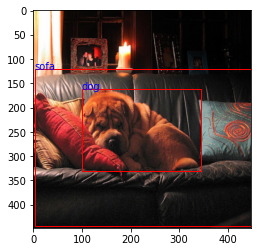

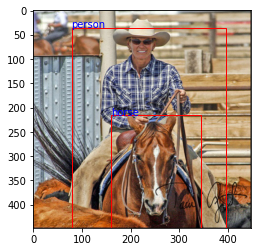

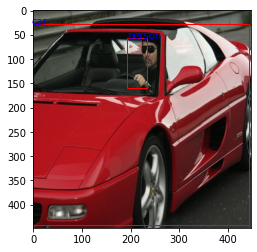

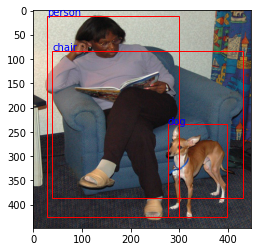

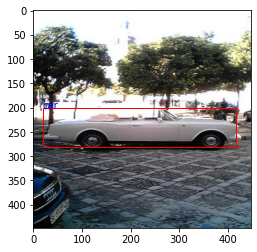

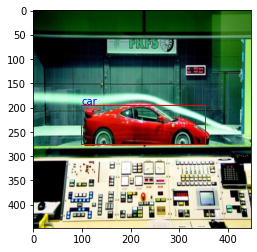

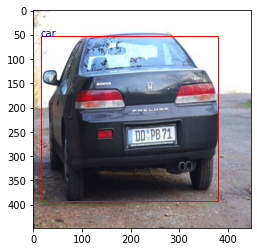

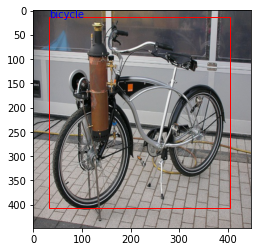

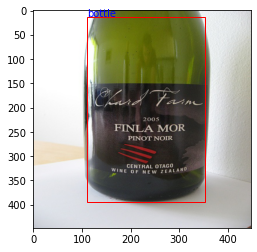

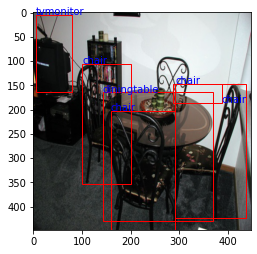

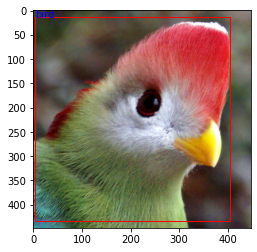

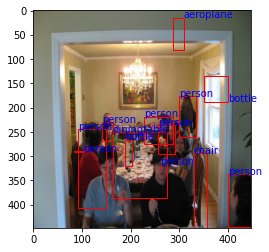

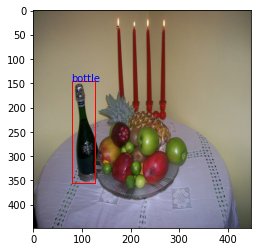

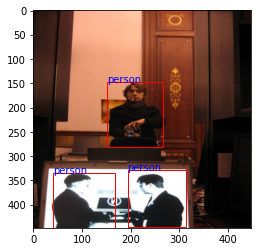

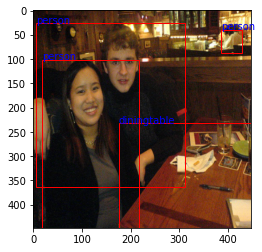

SystemExit: ignored

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [15]:
LEARNING_RATE = 2e-5
DEVICE = "cuda" if torch.cuda.is_available else "cpu"
BATCH_SIZE = 64
WEIGHT_DECAY = 0
EPOCHS = 100
NUM_WORKERS = 1
PIN_MEMORY = True
LOAD_MODEL = True
LOAD_MODEL_FILE = "overfit.pth.tar"
IMG_DIR = "train/VOCdevkit/VOC2007/JPEGImages"
LABEL_DIR = "train/VOCdevkit/VOC2007/labels"

if LOAD_MODEL:
  load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)
for epoch in range(EPOCHS):
  for x, y in train_loader:
      x = x.to(DEVICE)
      for idx in range(15):
          bboxes = cellboxes_to_boxes(model(x))
          bboxes = non_max_suppression(bboxes[idx], iou_threshold=0.5, threshold=0.4, box_format="midpoint")
          # print(len(bboxes))
          plot_image(x[idx].permute(1,2,0).to("cpu"), bboxes)

      import sys
      sys.exit()
